## DATA LOADING

In [155]:
import pandas as pd
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from scipy.stats import pearsonr

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.compose import make_column_selector as selector

from sklearn.metrics import r2_score
from collections import Counter
import math
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from meteostat import Stations, Daily

In [ ]:
Salaries_DF = pd.read_csv('CleanData/Salaries.csv')
Weather_DF = pd.read_csv('CleanData/Weather.csv')
Disasters_DF = pd.read_csv('CleanData/NaturalDisasters_Year.csv')
NaturalDisasters = pd.read_csv('CleanData/NaturalDisasters.csv')
NaturalDisasters_Original = pd.read_csv('CleanData/NaturalDisasters_Original.csv')
DeltaX_DF = pd.read_csv('CleanData/DeltaX.csv')
Relationships = pd.read_csv('CleanData/Relationships.csv')
AllRelationships = pd.read_csv('CleanData/AllRelationships.csv')
Filter_Result = pd.read_csv('CleanData/Result.csv')

fp_county="CleanData/Maps/US_COUNTY.shp"
county= gpd.read_file(fp_county).to_crs('epsg:4326')
county['state_county'] = county['STATE'] +' '+ county['COUNTY']

## NATURAL DISASTERS

In [ ]:
ExplanationDict = dict([
('Flood', 'flood'),
('Hurricane', 'hurricane'),
('Severe Storm(s)', 'storm'),
('Snow', 'snow'),
('Tornado', 'tornado'),
('Fire', 'fire'),
('Severe Ice Storm', 'icestorm'),
])

YearsInterval = [1953,2022]
NaturalDisasters_YearFilter = NaturalDisasters_Original.loc[(NaturalDisasters_Original['fyDeclared'] > YearsInterval[0]-1)
                                                       & (NaturalDisasters_Original['fyDeclared'] < YearsInterval[1]+1)]


NaturalDisasters_YearFilter = NaturalDisasters_YearFilter.groupby(['state_county','incidentType']).size().to_frame('size').reset_index()
for disaster in ['Flood', 'Hurricane', 'Severe Storm(s)','Snow', 'Tornado', 'Fire', 'Severe Ice Storm']:

    df = NaturalDisasters_YearFilter[NaturalDisasters_YearFilter['incidentType'] == disaster]
    fig = px.choropleth(df, geojson=county,
                        locations = "state_county",
                        featureidkey="properties.state_county",
                        color='size',
                        height=500,
                       color_continuous_scale="Viridis")
    fig.update_geos(fitbounds="geojson", visible=True)
    fig.update_layout(
        title_text= disaster + ' alerts by County between ' + str(YearsInterval[0]) + ' and ' + str(YearsInterval[1])
        )
    fig.update(layout = dict(title=dict(x=0.5)))
    fig.update_layout(
            margin={"r":0,"t":30,"l":10,"b":10},
            coloraxis_colorbar={
                'title': 'alerts'})
#    fig.show()
#    fig.write_image("images/" + ExplanationDict[disaster] + ".png")
    
Totals = NaturalDisasters_YearFilter.groupby('state_county').sum().reset_index()

fig = px.choropleth(Totals, geojson=county,
                        locations = "state_county",
                        featureidkey="properties.state_county",
                        color='size',
                        height=500,
                       color_continuous_scale="Turbo")
fig.update_geos(fitbounds="geojson", visible=True)
fig.update_layout(
        title_text= 'Total alerts by County between ' + str(YearsInterval[0]) + ' and ' + str(YearsInterval[1])
        )
fig.update(layout = dict(title=dict(x=0.5)))
fig.update_layout(
            margin={"r":0,"t":30,"l":10,"b":10},
            coloraxis_colorbar={
                'title': 'alerts'})


fig.show()
#fig.write_image("images/total.png")


## WEATHER

In [ ]:
ExplanationDict = dict([
('pcp', 'Precipitation'),
('anomaly_pcp', 'Precipitation Anomaly'),
('tmax', 'Max Temperature'),
('anomaly_tmax', 'Max Temperature Anomaly'),
('tmin', 'Min Temperature'),
('anomaly_tmin', 'Min Temperature Anomaly'),
('tavg', 'Average Temperature'),
('anomaly_tavg', 'Average Temperature Anomaly')
])

UnitsDict = dict([
('pcp', 'mm'),
('anomaly_pcp', 'mm'),
('tmax', '°F'),
('anomaly_tmax', '°F'),
('tmin', '°F'),
('anomaly_tmin', '°F'),
('tavg', '°F'),
('anomaly_tavg', '°F')
])

for Year in range(1992,2022):
    for category in['pcp','anomaly_pcp','tmax', 'anomaly_tmax','tmin', 'anomaly_tmin', 'tavg','anomaly_tavg']:
        fig = px.choropleth(Weather_DF[Weather_DF['year'] == Year], geojson=county,
                    locations = "state_county",
                    featureidkey="properties.state_county",
                    color=category,
                    height=500,
                    color_continuous_scale="Turbo")
        fig.update_geos(
                    fitbounds="geojson", visible=True)
        fig.update_layout(title_text= ExplanationDict[category] + ' by County in ' + str(Year))
        fig.update(layout = dict(title=dict(x=0.5)))
        fig.update_layout(
                    margin={"r":0,"t":30,"l":10,"b":10},
                    coloraxis_colorbar={
                    'title': UnitsDict[category]})
        #fig.write_image("images/" +str(Year) + "_" + category +".png")


## DATA FORECASTING

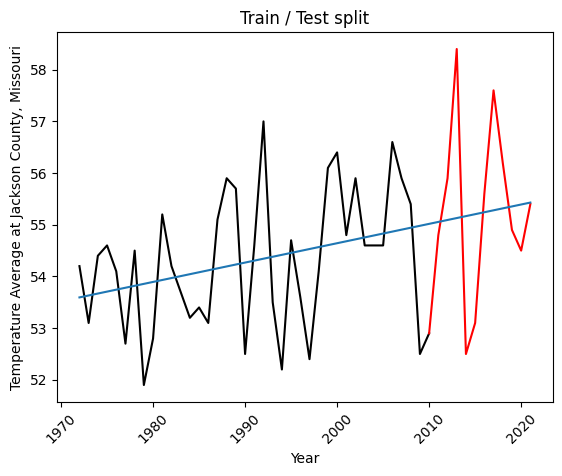

In [142]:
ChosenCounty = 'Missouri Jackson County'
ChosenCategory = 'tavg'

Filter_Weather = Weather_DF[Weather_DF['state_county'] == ChosenCounty]
Filter_Weather.index = pd.to_datetime(Filter_Weather['year'], format='%Y')

train = Filter_Weather[Filter_Weather.index <  pd.to_datetime("2011", format='%Y')]
test = Filter_Weather[Filter_Weather.index >  pd.to_datetime("2009", format='%Y')]

plt.plot(train.index.year, train[ChosenCategory], color = "black")
plt.plot(test.index.year,test[ChosenCategory], color = "red")
plt.ylabel('Temperature Average at Jackson County, Missouri')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.title("Train / Test split")

y= Filter_Weather[ChosenCategory]
x= Filter_Weather.index.year

m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b)

plt.show()

## SALARY

In [143]:
NameFileDict = dict([
('salary (thousands)', 'salary'),
('previous_year', 'previous_salary'),
('salary change', 'salary_change'),
('EMP', 'emp'),
('tmin', 'Min Temperature'),
('anomaly_tmin', 'Min Temperature Anomaly'),
('tavg', 'Average Temperature'),
('anomaly_tavg', 'Average Temperature Anomaly')
])


ExplanationDict = dict([
('salary (thousands)', 'Salary'),
('previous_year', 'Salary Previous Year'),
('salary change', 'Salary Change %'),
('EMP', 'Employees'),
])

UnitsDict = dict([
('salary (thousands)', 'thousands'),
('previous_year', 'thousands'),
('salary change', '%'),
('EMP', 'people'),
])

In [ ]:
for year in range(2012,2021):
    for category in ['salary (thousands)','salary change','EMP']:
        df = Salaries_DF[Salaries_DF['YEAR'] == year]
        fig = px.choropleth(df, geojson=county,
                    locations = "state_county",
                    featureidkey="properties.state_county",
                    color='salary (thousands)',
                    height=500,
                    color_continuous_scale="Turbo")
        fig.update_geos(fitbounds="geojson", visible=True)
        fig.update_layout(
        title_text= str(year) + ' ' + ExplanationDict[category]
        )
        fig.update(layout = dict(title=dict(x=0.5)))
        fig.update_layout(
            margin={"r":0,"t":30,"l":10,"b":10},
            coloraxis_colorbar={
                'title': UnitsDict[category]})
        #fig.show()
        #fig.write_image("images/" +str(year) + "_" + NameFileDict[category] +".png")

## p-value and correlation
The P-value is the probability that you would have found the current correlation if the real correlation coefficient was 0

In [ ]:
ExplanationDict = dict([
('pcp', 'Precipitation'),
('anomaly_pcp', 'Precipitation Anomaly'),
('tmax', 'Max Temperature'),
('anomaly_tmax', 'Max Temperature Anomaly'),
('tmin', 'Min Temperature'),
('anomaly_tmin', 'Min Temperature Anomaly'),
('tavg', 'Average Temperature'),
('anomaly_tavg', 'Average Temperature Anomaly')
])

for category in['pcp','anomaly_pcp','tmax', 'anomaly_tmax','tmin', 'anomaly_tmin', 'tavg','anomaly_tavg']:
    df = AllRelationships[AllRelationships['weather-column']==category]
    fig = px.choropleth(df, geojson=county,
                    locations = "county",
                    featureidkey="properties.state_county",
                    color='r',
                    height=500,
                    color_continuous_scale="Turbo")
    fig.update_geos(
                    fitbounds="geojson", visible=True)
    fig.update_layout(title_text= 'Correlation between ' + ExplanationDict[category] + ' and salary')
    fig.update(layout = dict(title=dict(x=0.5)))
    fig.update_layout(
                    margin={"r":0,"t":30,"l":10,"b":10},
                    coloraxis_colorbar={
                    'title': 'r'})
    fig.show()
    fig.write_image("images/"+category+"_correlation.png")
    
    
    fig = px.choropleth(df, geojson=county,
                    locations = "county",
                    featureidkey="properties.state_county",
                    color='p-value',
                    height=500,
                    color_continuous_scale="Turbo")
    fig.update_geos(
                    fitbounds="geojson", visible=True)
    fig.update_layout(title_text= 'p-value between ' + ExplanationDict[category] + ' and salary')
    fig.update(layout = dict(title=dict(x=0.5)))
    fig.update_layout(
                    margin={"r":0,"t":30,"l":10,"b":10},
                    coloraxis_colorbar={
                    'title': 'p-value'})
    fig.show()
    fig.write_image("images/"+category+"_pvalue.png")
    
    fig = px.choropleth(df, geojson=county,
                    locations = "county",
                    featureidkey="properties.state_county",
                    color='significance',
                    height=500,
                    color_discrete_map={'<0.5':'rgb(243,195,57)',
                                        '<0.05':'rgb(50,172,242)',
                                        '>0.5':'rgb(226,71,11)',
                                        '<0.1':'rgb(140,252,76)',
                                        '<0.01':'blueviolet'})
    fig.update_geos(
                    fitbounds="geojson", visible=True)
    fig.update_layout(title_text= 'significance between ' + ExplanationDict[category] + ' and salary')
    fig.update(layout = dict(title=dict(x=0.5)))
    fig.update_layout(
                    margin={"r":0,"t":30,"l":10,"b":10},
                    coloraxis_colorbar={
                    'title': 'α'})
    fig.show()
    fig.write_image("images/"+category+"_significance.png")

In [145]:
AllRelationships

,county,r,p-value,weather-column,significance
0,Alabama Franklin County,0.540988,0.132569,pcp,<0.5
1,Georgia Fannin County,0.285771,0.456010,pcp,<0.5
2,Iowa Kossuth County,0.769942,0.015227,pcp,<0.05
3,Oklahoma Ottawa County,0.131487,0.735965,pcp,>0.5
4,Pennsylvania Susquehanna County,0.312535,0.412883,pcp,<0.5
...,...,...,...,...,...
24499,Nebraska Knox County,-0.453451,0.220243,anomaly_tavg,<0.5
24500,Georgia Lowndes County,0.279690,0.466068,anomaly_tavg,<0.5
24501,Florida Dixie County,0.514573,0.156360,anomaly_tavg,<0.5
24502,Indiana Cass County,-0.232001,0.548060,anomaly_tavg,>0.5


## MODELING

In [146]:
X = Filter_Result.drop(['Salary','Salary change'], axis=1)
y = Filter_Result['Salary']

In [147]:
def RunModel (model):

 model = make_pipeline(preprocessor, model)
 _ = model.fit(x_train, y_train)
 predictions = model.predict(x_test)
 return (predictions, model.score(x_test, y_test))

def conditional_entropy(x,y):
     # entropy of x given y
     y_counter = Counter(y)
     xy_counter = Counter(list(zip(x,y)))
     total_occurrences = sum(y_counter.values())
     entropy = 0
     for xy in xy_counter.keys():
         p_xy = xy_counter[xy] / total_occurrences
         p_y = y_counter[xy[1]] / total_occurrences
         entropy += p_xy * math.log(p_y/p_xy)
     return entropy
def theil_u(x,y):
     s_xy = conditional_entropy(x,y)
     x_counter = Counter(x)
     total_occurrences = sum(x_counter.values())
     p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
     s_x = ss.entropy(p_x)
     if s_x == 0:
         return 1
     else:
         return (s_x - s_xy) / s_x

In [148]:
X['Year'] = X['Year'].astype(object)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)
numerical_columns = numerical_columns_selector(X)

df_Categorical = x_train[categorical_columns]
df_Numerical = x_train[numerical_columns]


numerical_preprocessor = StandardScaler()
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
 unknown_value=-1)
preprocessor = ColumnTransformer([
 ('categorical', categorical_preprocessor, categorical_columns)],
 remainder="passthrough")



In [149]:
predictions, score = RunModel(LinearRegression())
print('R2 score of Salary and Previous Year Salary: ', round(100*r2_score(Filter_Result['Salary'], Filter_Result['Previous Year Salary']),4))
print('R2 score of Salary and Predicted Values: ', round(100*score,2))


R2 score of Salary and Previous Year Salary:  92.8
R2 score of Salary and Predicted Values:  93.79


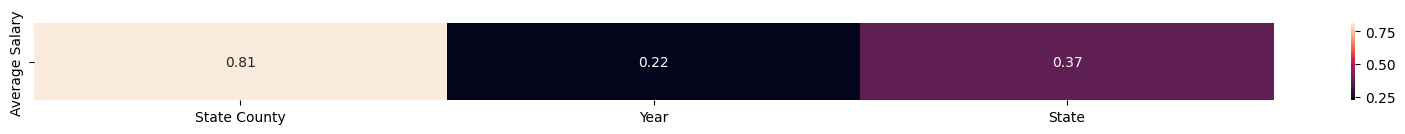

In [150]:
columns=df_Categorical.columns
theilu = pd.DataFrame(index=['Average Salary'],columns=columns)
for j in range(0,len(columns)):
    u = theil_u(y_train,x_train[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()
theilu = theilu.iloc[0].sort_values(ascending=False)

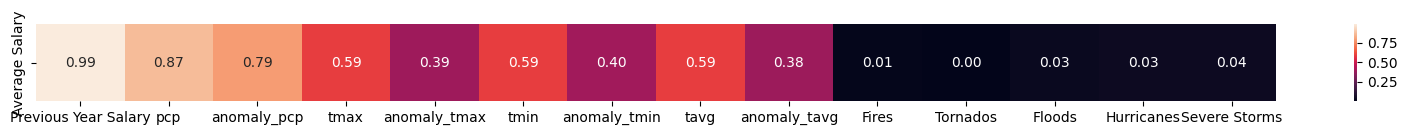

In [151]:
theilu = theilu[theilu > 0.1]
columns=df_Numerical.columns
theilu2 = pd.DataFrame(index=['Average Salary'],columns=columns)
for j in range(0,len(columns)):
    u = theil_u(y_train,x_train[columns[j]].tolist())
    theilu2.loc[:,columns[j]] = u

theilu2.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu2,annot=True,fmt='.2f')
plt.show()
theilu2 = theilu2.iloc[0].sort_values(ascending=False)
theilu2 = theilu2[theilu2 > 0.1]

## OLYMPEX

In [152]:
Sites = pd.read_csv('CleanData/Olympex_Temperature_RH_Data_Sites.csv')
Snow = pd.read_csv('CleanData/SnowSurvey.csv')
Snow.columns = [column.replace('\n',' ') for column in Snow.columns]

In [153]:
fig = px.choropleth_mapbox(county,
                        locations = "COUNTY",
                        featureidkey="properties.County",
                        height=500,
                        center={"lon": float(Snow['Latitude'].mean()), "lat": float(Snow['Longitude'].mean())},
                        zoom =7,
                        mapbox_style="open-street-map",
                       color_continuous_scale="YlGn")

fig.add_scattermapbox(
    lat = Snow['Longitude'],
    lon = Snow['Latitude'],
    mode = 'markers+text',
    marker_size=10,
    opacity = 0.1,
    marker_color='red'
)

fig.show()

In [154]:
X = Snow.drop(['Depth of Snow Inches'], axis=1)
y = Snow['Depth of Snow Inches']

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)
numerical_columns = numerical_columns_selector(X)

df_Categorical = x_train[categorical_columns]
df_Numerical = x_train[numerical_columns]


numerical_preprocessor = StandardScaler()
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
 unknown_value=-1)
preprocessor = ColumnTransformer([
 ('categorical', categorical_preprocessor, categorical_columns)],
 remainder="passthrough")

predictions, score = RunModel(LinearRegression())
print('R2 score of Prediction for Snow Density: ', round(100*score,2))

R2 score of Prediction for Snow Density:  97.88


In [156]:
id_stations = []
AllDailyData = pd.DataFrame()
AllDailyData = AllDailyData.drop_duplicates()
i = 0
for row in Snow.iterrows():

    stations = Stations()
    row = row[1]
    stations = stations.nearby(row['Longitude'],row['Latitude'])
    INDEXES = stations.fetch(5).index
    start = datetime(2016, 1, 1)
    end = datetime(2017, 1, 1)
    Winner_NAN = 100000
    Winner_StationId = 1
    Winner_NumberDays = 1
    for weatherstation in INDEXES:
        temp = Daily(weatherstation, start, end).fetch()
        temp_NAN = temp.isna().sum().sum()
        temp_NumberDays = len(temp.index)
        

        if temp_NumberDays/0.95 > Winner_NumberDays:
            Winner_NAN = temp_NAN
            Winner_StationId = weatherstation
            Winner_NumberDays = temp_NumberDays
            
            if temp_NAN < Winner_NAN:
                Winner_NAN = temp_NAN
                Winner_StationId = weatherstation
                Winner_NumberDays = temp_NumberDays
    DailyData = Daily(Winner_StationId, start, end).fetch()
    
    DailyData['Site'] = row['Site']
        
    AllDailyData = pd.concat([AllDailyData, DailyData])
    i = i+1
    
AllDailyData = AllDailyData.drop_duplicates()
AllDailyData = AllDailyData.reset_index().set_index(['time','Site'])

In [158]:
ListofRows = []
i = 0
for row in Snow.iterrows():
    try:
        row = row[1]
        Date = row['Date']
        Site = row['Site']
        rowDict = dict(AllDailyData.loc[Date,Site])
        ListofRows.append(rowDict)
        i=i+1
        
    except:
        i=i+1
        ListofRows.append({})
        pass

In [159]:
Weather_Snow = pd.DataFrame(ListofRows)

In [160]:
Result = pd.concat([Snow.reset_index(drop=True),Weather_Snow.reset_index(drop=True)], axis=1)
Result2 = Result.dropna(axis=1, how="all", thresh=None, subset=None, inplace=False).fillna(0)

In [161]:
X = Result2.drop(['Depth of Snow Inches'], axis=1)
y = Result2['Depth of Snow Inches']

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)
numerical_columns = numerical_columns_selector(X)

df_Categorical = x_train[categorical_columns]
df_Numerical = x_train[numerical_columns]


numerical_preprocessor = StandardScaler()
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
 unknown_value=-1)
preprocessor = ColumnTransformer([
 ('categorical', categorical_preprocessor, categorical_columns)],
 remainder="passthrough")

predictions, score = RunModel(LinearRegression())

print('R2 score of Prediction for Snow Density: ', round(100*score,2))

R2 score of Prediction for Snow Density:  98.63
